In [425]:
import time
from copy import deepcopy

import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

In [426]:
dataset = pd.read_csv('../datasets/simple.csv', header=0, usecols=['x', 'y'], names=['x', 'y'])
dataset.describe()

,x,y
count,300.000000,300.000000
mean,50.936667,51.205051
std,28.504286,29.071481
min,0.000000,-3.467884
25%,27.000000,25.676502
50%,53.000000,52.170557
75%,73.000000,74.303007
max,100.000000,105.591837


In [427]:
# Modified this template in the following ways:
# * All class and function names were changed to snake_case style.
# * An Individual's cost is calculated by a function called within the genetic algorithm (for thread optimization).
# * Chromosomes have a min/max for each element

class problem:
  def __init__(self):
    self.number_of_genes = 2
    self.mins = [0.000001, 0.000001]
    self.maxs = [1, 1] # These values could be much more optimal, but I think it's interesting to see how the algorithm works from very bad costs
  def build_chromosome(self, genes=None): # Verify all chromosomes created remain in bounds without repeating code
    chromosome = []

    for i in range(self.number_of_genes):
      if(genes is None or len(genes) <= i):
        chromosome.append(np.random.uniform(self.mins[i], self.maxs[i]))
      else:
        chromosome.append(np.clip(genes[i], self.mins[i], self.maxs[i]))
    return np.asarray(chromosome, dtype=float)

class parameters:
  def __init__(self):
    self.population = 10
    self.maximum_number_of_generations = 100
    self.crossover_exploration = 0.1
    self.mutation_rate = 0.2
    self.mutation_range = 0.1
    self.child_factor = 1

In [428]:
# Dataset prep

COL_X_LABEL = 'x'
COL_Y_LABEL = 'y'

scaler = StandardScaler()

In [429]:
RANDOM_SEED = 100
SAMPLE_SIZE = 1 # TODO: params. The percentage of the dataset used in the optimization algorithm, forming the train/validate/test sets.

dataset_sampled = dataset.sample(frac=SAMPLE_SIZE, random_state=RANDOM_SEED)

train_data, test_data = np.split(dataset_sampled, [int(.8 * len(dataset_sampled))])
train_data, test_data = train_data.transpose(), test_data.transpose()

In [430]:
# The individual is a unique linear regression model.
# All individuals use the same training, validation, and test sets.

# Create training, validation, and test sets.
    # Shuffle dataset
RANDOM_SEED = 100
SAMPLE_SIZE = 1 # TODO: params. The percentage of the dataset used in the optimization algorithm, forming the train/validate/test sets.
dataset_sampled = dataset.sample(frac=SAMPLE_SIZE, random_state=RANDOM_SEED)
data_scaled = scaler.fit_transform(dataset_sampled[[COL_X_LABEL, COL_Y_LABEL]])
train_data, test_data = np.split(data_scaled, [int(.8 * len(data_scaled))])
train_data, test_data = train_data.transpose(), test_data.transpose()

class individual:
  def __init__(self, prob):
    self.problem = prob
    self.chromosome = self.problem.build_chromosome()
    self.model = None
    self.cost = np.nan

  def crossover(self, other, epsilon):
    child1 = deepcopy(self)
    child2 = deepcopy(other)

    alpha = np.random.uniform(-epsilon,1+epsilon)
    
    c1 = alpha*self.chromosome + (1-alpha)*other.chromosome
    c2 = (1-alpha)*self.chromosome + alpha*other.chromosome
    
    child1.chromosome = self.problem.build_chromosome(c1)
    child2.chromosome = self.problem.build_chromosome(c2)
    return child1, child2

  def mutate(self,mutation_rate,mutation_range):
    chromosome = []
    for i in range(len(self.chromosome)):
      if np.random.uniform(0,1) < mutation_rate:
        chromosome.append(self.chromosome[i] + np.random.randn()*mutation_range)
      else:
        chromosome.append(self.chromosome[i])
    self.chromosome = self.problem.build_chromosome(chromosome)

  def calculate_cost(self):
    model = SGDRegressor(
        learning_rate = 'constant',
        eta0 = self.chromosome[0], # Learning-rate
        penalty = 'l2', # Regularization type
        alpha = self.chromosome[1], # Regularization type
        max_iter = 1000
    ) # TODO: add tolerance and random state

    self.train_time = np.nan
    self.mse = np.nan

    # Fit model and calculate time-till-convergence
    start = time.perf_counter()
    model.fit(train_data[0].reshape(-1, 1), train_data[1])
    end = time.perf_counter()
    time_seconds = end-start
    self.train_time = time_seconds
      
    predictions = model.predict(test_data[0].reshape(-1, 1))
    self.mse = mean_squared_error(test_data[1], predictions)
      
    # Temporary idea, mse (already a 'cost' function) is amplified by time
    self.cost = self.mse * (1 + time_seconds)
    return self.cost

In [431]:
# TODO: Update to tournament or other method
def get_parents(population):
  index1 = np.random.randint(0, len(population))
  index2 = np.random.randint(0, len(population))
  if index1 == index2:
    return get_parents(population)
  parent1 = population[index1]
  parent2 = population[index2]
  return parent1, parent2

In [432]:
def run_genetic(prob, params):
  # Read in variables from problem and the parameters
  number_in_population = params.population
  maximum_number_of_generations = params.maximum_number_of_generations
  crossover_exploration = params.crossover_exploration
  mutation_rate = params.mutation_rate
  mutation_range = params.mutation_range
  children_per_generation = number_in_population * params.child_factor
  # Generate the initial population
  population = []
  best_solution = individual(prob)
  best_cost = np.inf
  for i in range(number_in_population):
    new_individual = individual(prob)
    new_individual.calculate_cost()
    if new_individual.cost < best_cost:
      best_cost = new_individual.cost
      best_solution = deepcopy(new_individual)
    population.append(new_individual)
  print(f"Best initial: {best_solution.mse}")

  # Iterate from here for each generation
  for generation in range(maximum_number_of_generations):
      # produce children until correct amount
      children = []
      while len(children) < children_per_generation:
          # choose parents
          parent1, parent2 = get_parents(population)
          # mate parents
          child1, child2 = parent1.crossover(parent2,crossover_exploration)
              # mate producing 2 children (Crossover)
              # mutate the children
          child1.mutate(mutation_rate, mutation_range)
          child2.mutate(mutation_rate, mutation_range)
              # calculate child cost
          child1.calculate_cost()
          child2.calculate_cost()
          children.append(child1)
          children.append(child2)
              # add to population
      population += children
      # cull the population
      population = sorted(population, key=lambda x: x.cost)
      population = population[:number_in_population]
      if population[0].cost<best_solution.cost:
        best_solution = deepcopy(population[0])
        best_cost = best_solution.cost
        print(f"Better: {best_solution.mse}")

      
  return best_solution

In [433]:
# This individual should contain the best values to train a full model
best = run_genetic(problem(), parameters())

model = SGDRegressor(
    learning_rate = 'constant',
    eta0 = best.chromosome[0], # Learning-rate
    penalty = 'l2', # Regularization type
    alpha = best.chromosome[1], # Regularization type
    max_iter = 1000
)
model
best.mse

Best initial: 0.009516615040865043
Better: 0.008395831158086831
Better: 0.008305549591182583
Better: 0.0082884651648157
Better: 0.0082869224897299
Better: 0.008267013726503262


0.008267013726503262

In [434]:
start = time.perf_counter()
model.fit(train_data[0].reshape(-1, 1), train_data[1])
end = time.perf_counter()
time_seconds = end-start
  
predictions = model.predict(test_data[0].reshape(-1, 1))
mse = mean_squared_error(test_data[1], predictions)

print(f"Model trained in {time_seconds} seconds, with a MSE of {mse}")

Model trained in 0.0007619000007252907 seconds, with a MSE of 0.008519820825377618


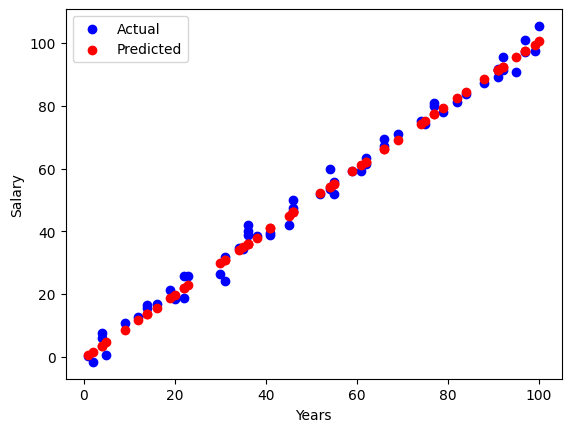

In [435]:
import matplotlib.pyplot as plt

unscaled = scaler.inverse_transform(test_data.T).T
unscaled_predictions = np.zeros((len(predictions), 2)).T
unscaled_predictions[1] = predictions
unscaled_predictions = scaler.inverse_transform(unscaled_predictions.T).T[1]

plt.scatter(unscaled[0].reshape(-1, 1), unscaled[1], label='Actual', color='blue')
plt.scatter(unscaled[0].reshape(-1, 1), unscaled_predictions, label='Predicted', color='red')
plt.xlabel('Years')
plt.ylabel('Salary')
plt.legend()
plt.show()